This model is based off of a neural network that performed well (> 99% accuracy) in model 2 for one of the authors (Purkeypile).

In [1]:
# all imports here to make it easy to pick up when
# the run time restarts
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import os
import opendatasets as od
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.nn.functional import one_hot
from keras.utils import to_categorical
import shutil

# seed the random number generator for consistent results
# from run to run
random.seed(1234)

In [2]:
# loading of the data in this cell based on Maha's cv_project 
od.download("https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification")

# Define the path to the main images folder
IMAGE_DIR = './recyclable-and-household-waste-classification/images/images'
TRAIN_DIR = './split_dataset/train/images'
TEST_DIR = './split_dataset/test/images'
#VALIDATION_DIR = './split_dataset/val/images'   # not using, but would be easy to do

# Traverse the subdirectories and list images
image_paths = []
for root, dirs, files in os.walk(IMAGE_DIR):
    for file in files:
        # Append full path for each image file
        image_paths.append(os.path.join(root, file))


Skipping, found downloaded files in ".\recyclable-and-household-waste-classification" (use force=True to force download)


In [3]:
# Print total number of images
print(len(image_paths))

15000


./recyclable-and-household-waste-classification/images/images\shoes\default\Image_99.png


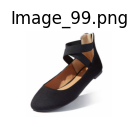

./recyclable-and-household-waste-classification/images/images\newspaper\default\Image_72.png


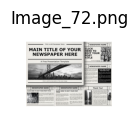

./recyclable-and-household-waste-classification/images/images\cardboard_boxes\real_world\Image_247.png


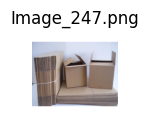

./recyclable-and-household-waste-classification/images/images\aerosol_cans\default\Image_209.png


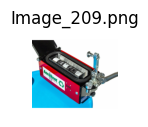

./recyclable-and-household-waste-classification/images/images\aluminum_soda_cans\real_world\Image_86.png


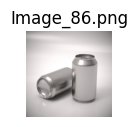

In [4]:
# Display a few random sample images
NUM_SAMPLES_TO_DISPLAY = 5

for i in range(NUM_SAMPLES_TO_DISPLAY):
    image_path = image_paths[random.randrange(len(image_paths))]
    print(image_path)
    image = Image.open(image_path)

    # Display the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
    plt.show()

In [5]:
DEFAULT_DIR = "default"
REAL_WORLD_DIR = "real_world"

# clear the test and train directories. otherwise from run to 
# run more images will be copied into them, resulting in train
# and testing containing some of the same images
shutil.rmtree(TRAIN_DIR)
shutil.rmtree(TEST_DIR)

# Ensure directories exist
os.makedirs(TRAIN_DIR, exist_ok = True)
os.makedirs(TEST_DIR, exist_ok = True)

def default_or_realworld(image_path):
    # this is kind of hacky to look for it as a string
    # a better way would be to step "up" one directory and see what it is
    if DEFAULT_DIR in image_path.lower():
        return DEFAULT_DIR
    elif REAL_WORLD_DIR in image_path.lower():
        return REAL_WORLD_DIR
    else:
        raise ValueError(image_path + " does not contain " + DEFAULT_DIR + " or " + REAL_WORLD_DIR)

# Process each class in the source directory
num_classes = 0
for class_name in os.listdir(IMAGE_DIR):
    class_path = os.path.join(IMAGE_DIR, class_name)
    if os.path.isdir(class_path):  # Ensure it’s a directory (class folder)
        num_classes += 1
        print("Processing " + class_name + "... (" + str(num_classes) + " classes so far)")
        
        # Create class folders in train and test directories
        os.makedirs(os.path.join(TRAIN_DIR, class_name), exist_ok = True)
        os.makedirs(os.path.join(TEST_DIR, class_name), exist_ok = True)

        # Collect all image file paths from any subdirectories within this class folder
        images = []
        for root, _, files in os.walk(class_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image file extensions
                    images.append(os.path.join(root, file))

        # Shuffle and split images into 80/20 train/test
        random.shuffle(images)
        split_idx = int(len(images) * 0.8)
        train_images = images[: split_idx]
        test_images = images[split_idx :]

        # Copy images to train and test directories
        # there are duplicate file names in the default and real
        # world directories, so add that onto the names to make them
        # unique. also only copy if not already present so subsequent
        # runs are faster if this is already done
        for image_path in train_images:
            dest_path = os.path.join(TRAIN_DIR, class_name, default_or_realworld(image_path) + os.path.basename(image_path))
            if os.path.exists(dest_path) == False:
                shutil.copyfile(image_path, dest_path)

        for image_path in test_images:
            dest_path = os.path.join(TEST_DIR, class_name, default_or_realworld(image_path) + os.path.basename(image_path))
            if os.path.exists(dest_path) == False:
                shutil.copyfile(image_path, dest_path)

print("Dataset successfully split into train and test folders!")

Processing aerosol_cans... (1 classes so far)
Processing aluminum_food_cans... (2 classes so far)
Processing aluminum_soda_cans... (3 classes so far)
Processing cardboard_boxes... (4 classes so far)
Processing cardboard_packaging... (5 classes so far)
Processing clothing... (6 classes so far)
Processing coffee_grounds... (7 classes so far)
Processing disposable_plastic_cutlery... (8 classes so far)
Processing eggshells... (9 classes so far)
Processing food_waste... (10 classes so far)
Processing glass_beverage_bottles... (11 classes so far)
Processing glass_cosmetic_containers... (12 classes so far)
Processing glass_food_jars... (13 classes so far)
Processing magazines... (14 classes so far)
Processing newspaper... (15 classes so far)
Processing office_paper... (16 classes so far)
Processing paper_cups... (17 classes so far)
Processing plastic_cup_lids... (18 classes so far)
Processing plastic_detergent_bottles... (19 classes so far)
Processing plastic_food_containers... (20 classes so

In [6]:
# return the valid ones too, cause if the directory
# doesn't exist then there are 0 invalid and it 
# seems like everything is ok when it isn't.
def check_images(directory):
    invalid_images = []
    valid_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.png'):
                try:
                    img = Image.open(os.path.join(root, file))
                    # note: this returns none and throws an exception if invalid
                    # (I was expecting it to return a bool- exceptions shouldn't
                    # be used for flow control)
                    img.verify()  # Verify image integrity
                    valid_images.append(os.path.join(root, file))
                except Exception as e:
                    invalid_images.append(os.path.join(root, file))
    return valid_images, invalid_images

valid_train, invalid_train = check_images(TRAIN_DIR)
valid_test, invalid_test = check_images(TEST_DIR)

print("Valid train images: " + str(len(valid_train)) + ", invalid train images: " + str(len(invalid_train)))
print("Valid test images: " + str(len(valid_test)) + ", invalid test images: " + str(len(invalid_test)))

total_found = (len(valid_train) + len(invalid_train) + len(valid_test) + len(invalid_test))
print("Total images found in training and testing sets: " + str(total_found))
print("Expected images from source: " + str(len(image_paths)))
if  total_found != len(image_paths):
    print("MISSING FILES IN TESTING OR TRAINING SET!!!")
else:
    print("Found all expected files in training and testing")

Valid train images: 12000, invalid train images: 0
Valid test images: 3000, invalid test images: 0
Total images found in training and testing sets: 15000
Expected images from source: 15000
Found all expected files in training and testing


In [7]:
IMG_SIZE = 224
BATCH_SIZE = 64

def one_hot_encoding(target):
    #return one_hot(target, num_classes=num_classes)   # needs a tensor, not an int
    return to_categorical(target, num_classes)

# Define data transformations
# numbers based on Maha's code
custom_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize images to a consistent size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

## Load datasets
train_dataset = ImageFolder(root = TRAIN_DIR, transform = custom_transform, target_transform = one_hot_encoding)
test_dataset = ImageFolder(root = TEST_DIR, transform = custom_transform, target_transform = one_hot_encoding)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [8]:
# there is a very small, but non-zero chance that one of
# the data sets is missing an entire class- so account for that
train_class_names = train_dataset.classes
test_class_names = test_dataset.classes

class_names = set(train_class_names + test_class_names)

print("Class labels:", class_names)

check_num_classes = len(class_names)
print("\nNumber of classes from datasets: " + str(check_num_classes))
print("Number of classes from initial processing: " + str(num_classes))
if check_num_classes != num_classes:
    print("NUMBER OF CLASSES MISMATCH")

Class labels: {'plastic_trash_bags', 'magazines', 'plastic_straws', 'glass_beverage_bottles', 'shoes', 'glass_food_jars', 'eggshells', 'plastic_soda_bottles', 'office_paper', 'plastic_cup_lids', 'aluminum_soda_cans', 'tea_bags', 'styrofoam_cups', 'styrofoam_food_containers', 'plastic_detergent_bottles', 'aerosol_cans', 'disposable_plastic_cutlery', 'newspaper', 'glass_cosmetic_containers', 'coffee_grounds', 'cardboard_packaging', 'plastic_shopping_bags', 'steel_food_cans', 'cardboard_boxes', 'aluminum_food_cans', 'clothing', 'plastic_food_containers', 'plastic_water_bottles', 'paper_cups', 'food_waste'}

Number of classes from datasets: 30
Number of classes from initial processing: 30


In [9]:
# if you play around with this you can see they're 
# sorted by target
start_index = -50
for i in range(start_index, start_index + 10):
    print(train_dataset[i][1])   # print the target/label

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1.]


In [18]:
#### RAW COPY FROM MODULE 2- NEED TO UPDATE ####
# based on the following:
# https://medium.com/@BrendanArtley/mnist-keras-simple-cnn-99-6-731b624aee7f
from tensorflow.keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras import backend as K

DROP_OUT_RATE = 0.05

model = Sequential()

if K.image_data_format() == 'channels_first':
    cur_data_format = 'channels_first'
else:
    cur_data_format = 'channels_last'
print("cur_data_format = " + cur_data_format)
    
#model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format=cur_data_format,
#                 input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format=cur_data_format,
                 input_shape=(3, IMG_SIZE, IMG_SIZE)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
model.add(Dropout(DROP_OUT_RATE))

#model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format=cur_data_format))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
#model.add(Dropout(DROP_OUT_RATE))

#model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format=cur_data_format))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
#model.add(Dropout(DROP_OUT_RATE))

#model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format=cur_data_format))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
#model.add(Dropout(DROP_OUT_RATE))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(DROP_OUT_RATE))

model.add(Dense(num_classes, activation='softmax'))

cur_data_format = channels_last


In [27]:
# based on the following:
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from keras import backend as K
import numpy as np

def recall_m(y_true, y_pred):
    true_positives = sum(round(np.clip(y_true * y_pred, 0, 1)))
    possible_positives = sum(round(np.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = sum(round(np.clip(y_true * y_pred, 0, 1)))
    predicted_positives = sum(round(np.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [28]:
NUM_EPOCHS = 20

print(model.summary())
print()

model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy', f1_m,precision_m, recall_m])

hist = model.fit(train_loader, epochs = NUM_EPOCHS, batch_size = BATCH_SIZE,
                 validation_data = test_loader, verbose = 1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 3, 224, 32)          │          64,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 224, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 112, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 112, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3584)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,835,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 30)                  │          15,390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,750,716 (21.94 MB)

 Trainable params: 1,916,542 (7.31 MB)

 Non-trainable params: 1,088 (4.25 KB)

 Optimizer params: 3,833,086 (14.62 MB)

None

Epoch 1/20


TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type float64 of argument 'x'.

In [17]:
for cur_key in hist.history.keys():
    print(cur_key + " = " + str(hist.history[cur_key]))
    print()

accuracy = [0.21158333122730255, 0.35499998927116394, 0.4559166729450226, 0.5514166951179504, 0.6428333520889282, 0.7118333578109741, 0.778249979019165, 0.8274999856948853, 0.8669999837875366, 0.8866666555404663, 0.9090833067893982, 0.9160833358764648, 0.9294999837875366, 0.9359166622161865, 0.9335833191871643, 0.9370833039283752, 0.9379166960716248, 0.9443333148956299, 0.9419999718666077, 0.9479166865348816]

loss = [2.995389223098755, 2.3862464427948, 1.9768568277359009, 1.623854637145996, 1.289955496788025, 1.022831916809082, 0.7934186458587646, 0.6251835227012634, 0.4909130334854126, 0.4030868411064148, 0.3304517865180969, 0.2966245710849762, 0.24885302782058716, 0.23591305315494537, 0.23088359832763672, 0.21443530917167664, 0.21299737691879272, 0.19185003638267517, 0.19440427422523499, 0.17376822233200073]

val_accuracy = [0.28166666626930237, 0.3153333365917206, 0.3776666522026062, 0.44999998807907104, 0.4753333330154419, 0.49399998784065247, 0.5136666893959045, 0.560666680335998

In [ ]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose = 1)
print("loss = " + str(loss))
print("accuracy = " + str(accuracy))
print("f1 score = " + str(f1_score))
print("precision = " + str(precision))
print("recall = " + str(recall))

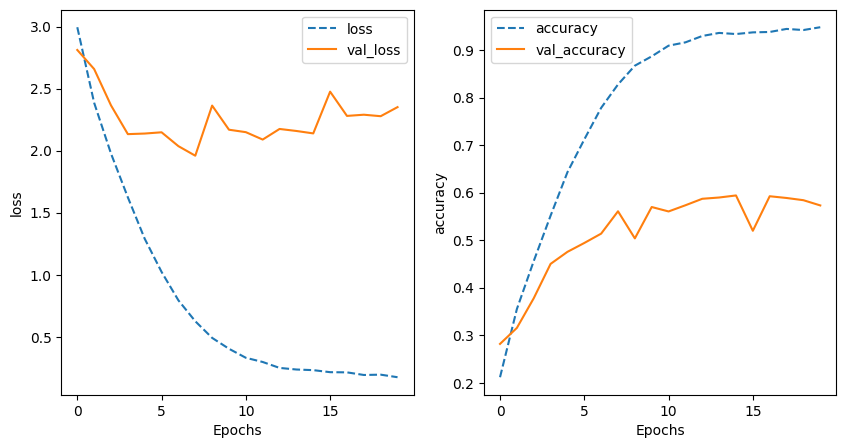

In [13]:
# Draw Learning curve
def learning_curve(hist):
  #Create a function to draw learning curves
  # This will help you to just call this function in future for drawing the learning curves
  metrics = ['loss', 'accuracy']
  # based on the lab
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(hist.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(hist.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])
    
learning_curve(hist)